# 数据挖掘大作业二：关联规则挖掘

## 一、对数据集进行处理，转换成适合关联规则挖掘的形式（TouTube/USvideos.csv数据集）

### 因为主要选用经典的Apriori算法进行关联规则挖掘，而Apriori算法适用于对布尔属性（即二值属性）进行分析，因此为了提高分析效率，在数据预处理阶段主要想法是设计方案使得原数据中的多值属性转换为二值属性（虽然转换成二值属性会丢失一些信息，但尝试了不转换发现运行过慢）

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
df = pd.read_csv("/home/wangxuefei/Downloads/Dataset/youtube-new/USvideos.csv")

### 打印原数据集中的前5行，熟悉一下数据集

In [2]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


## 1、数据压缩

### 分析：  原数据集一共含有16个属性，考虑到数据转换的实际情况，这里主要选取了价值较高的9列进行关联规则挖掘，分别为：publish_time 	、views、likes、dislikes、comment_count、comments_disabled、ratings_disabled、video_error_or_removed、category_id（video_id虽保留，但并未实际使用，只是作为标识），其他属性如thumbnail_link、description等价值较低且不易转换，故舍弃。

#### 将选取的属性保存到一个新的data_select.csv文件中

In [3]:
output='/home/wangxuefei/Data_mining/data_select.csv'

def readwrite(output_file):
    data_1 = df
    data_1[['video_id','publish_time', 'views', 'likes', 'dislikes', 'comment_count', 'comments_disabled', 'ratings_disabled',
            'video_error_or_removed','category_id']].to_csv(output_file, sep=',', header=True,index=False)
readwrite(output)

#### 打印data_select.csv文件前5行内容，如下表所示

In [4]:
pd.read_csv("/home/wangxuefei/Data_mining/data_select.csv").head()

,video_id,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id
0,2kyS6SvSYSE,2017-11-13T17:13:01.000Z,748374,57527,2966,15954,False,False,False,22
1,1ZAPwfrtAFY,2017-11-13T07:30:00.000Z,2418783,97185,6146,12703,False,False,False,24
2,5qpjK5DgCt4,2017-11-12T19:05:24.000Z,3191434,146033,5339,8181,False,False,False,23
3,puqaWrEC7tY,2017-11-13T11:00:04.000Z,343168,10172,666,2146,False,False,False,24
4,d380meD0W0M,2017-11-12T18:01:41.000Z,2095731,132235,1989,17518,False,False,False,24


## 2、数据转化：转换成0-1矩阵

### 因为要将多值属性表示成二值（0\1），出于第一次作业对原始数据集分析的观察采用如下转换策略：

（1）对于publish_time 属性，大体上分布在2017年和2018年（有极少数的其他时间，忽略不计），所以这里发布时间为2017年的用‘0’表示， 发布时间为2018年的用‘1’表示；

（2）views、likes、dislikes、comment_count四个属性均为连续型数值属性，根据其分布特点，选择将大于其‘中位数’的值表示为‘1’，小于其‘中位数’的值表示为‘0’；

（3）comments_disabled、ratings_disabled、video_error_or_removed分别为三个布尔属性，因为绝大多数值为False,为了防止矩阵过于稀疏，这里将取False的值表示为‘1’，取True的值表示为‘0’；

（4）category_id为连续型数值属性，因为此属性较为关键，且值所分布的范围较小，所以没有同（2）进行相同的处理，而是单独处理。category_id的值分布在1～43之间，且大多持集中在15~25的区间内，所以这里将其划分为三个区间，分别为1~15、 15~25、 25以上，并分别用三个二值字段category_id_1、 category_id_2、 category_id_3表示（原来的category_id删掉）。
代码如下：

In [5]:
df2 = pd.read_csv("/home/wangxuefei/Data_mining/data_select.csv")
df2['publish_time'] = np.where(df2['publish_time'].str.match('2017'),0,1)

def data_process1(data):
    for col in ('views','likes','dislikes','comment_count'):
        data[col] = np.where(data[col] < data[col].median(),0,1)
    return data
df2=data_process1(df2)

def data_process2(data):
    for col in ('comments_disabled','ratings_disabled','video_error_or_removed'):
        data[col] = np.where(data[col]==False,1,0)
    return data
df2=data_process2(df2)

df2['category_id_1']=np.where(df2['category_id'] <= 15,1,0)
df2['category_id_2']=np.where(((df2['category_id'] > 15) & (df2['category_id'] <= 25)),1,0)
df2['category_id_3']=np.where(df2['category_id'] > 25,1,0)

del df2['category_id']
df2.to_csv('/home/wangxuefei/Data_mining/data_matrix.csv', sep=',', header=True,index=False)


#### 将数据预处理最后得到的0-1矩阵保存到data_matrix.csv中，打印前5行数据如下表所示：

In [6]:
pd.read_csv("/home/wangxuefei/Data_mining/data_matrix.csv").head()

,video_id,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id_1,category_id_2,category_id_3
0,2kyS6SvSYSE,0,1,1,1,1,1,1,1,0,1,0
1,1ZAPwfrtAFY,0,1,1,1,1,1,1,1,0,1,0
2,5qpjK5DgCt4,0,1,1,1,1,1,1,1,0,1,0
3,puqaWrEC7tY,0,0,0,1,1,1,1,1,0,1,0
4,d380meD0W0M,0,1,1,1,1,1,1,1,0,1,0


## 二、找出频繁项集

In [7]:
def preProcessing(data, vote_1_0):
    '''
    数据预处理
    以按 1 或 0 寻找关联规则
    '''
    data_pre = []
    for index, row in data.iterrows():
        tmp_data = []
        #print(row)
        for i in range(1, len(row)):

            if (row[i] == vote_1_0):
                tmp_data.append(data.columns.values.tolist()[i])

        if (tmp_data == []):
            continue
        data_pre.append(tmp_data)
    return data_pre

### 进行第一次挖掘，找到L_1项集

In [8]:
def mining_first(data, suport, coincidence):
    '''
    进行第一次挖掘
    挖掘候选1-项集
    '''
    dic = {}
    count = len(data)
    for data_line in data:
        for data_item in data_line:
            if (data_item in dic):
                dic[data_item] += 1
            else:
                dic[data_item] = 1

    assert (suport >= 0) and (suport <= 1), 'suport must be in 0-1'
    val_suport = int(count * suport)
    assert (coincidence >= 0) and (coincidence <= 1), 'coincidence must be in 0-1'
    dic_1 = {}
    for item in dic:
        if (dic[item] >= val_suport):
            dic_1[item] = dic[item]

    return dic_1

#### 设置支持度为0.3，置信度为0.8， 输出L_1项集

In [9]:
data = pd.read_csv("/home/wangxuefei/Data_mining/data_matrix.csv")
# 支持度
suport = 0.3
# 置信度
coincidence = 0.8
data_1 = preProcessing(data, 1) #按照1寻找关联规则
#data_0 = preProcessing(data, 0)#按照0寻找关联规则
dic_1 = mining_first(data_1, suport, coincidence)
print(dic_1)

{'publish_time': 30521, 'views': 20475, 'dislikes': 20483, 'comments_disabled': 40316, 'ratings_disabled': 40780, 'comment_count': 20478, 'category_id_2': 22511, 'likes': 20475, 'video_error_or_removed': 40926}


### 进行第二次挖掘，找到L_2项集

In [10]:
def mining_second(data, dic_before, suport, coincidence):
    '''
    进行关联规则的二次挖掘
    挖掘出候选2-项集
    '''
    dic = {}
    count = len(data)
    count2 = 0
    for data_line in data:
        # 获取元素数量
        count_item = len(data_line)
        # 每两个组合计数
        for i in range(0, count_item - 1):
            for j in range(i + 1, count_item):
                if (data_line[i] in dic_before and data_line[j] in dic_before):
                    count2 += 1
                    tmp = (data_line[i], data_line[j])
                    if (tmp in dic):
                        dic[tmp] += 1
                    else:
                        dic[tmp] = 1
                else:
                    continue
    # print(dic)
    assert (suport >= 0) and (suport <= 1), 'suport must be in 0-1'
    assert (coincidence >= 0) and (coincidence <= 1), 'coincidence must be in 0-1'

    dic_2 = {}
    for item in dic:
        count_item0 = dic_before[item[0]]
        count_item1 = dic_before[item[1]]
        # 判断 支持度 和 置信度
        if ((dic[item] >= suport * count) and (
                (dic[item] >= coincidence * count_item0) or (dic[item] >= coincidence * count_item1))):
            dic_2[item] = dic[item]

    return dic_2

#### 输出L_2项集

In [11]:
dic_2 = mining_second(data_1, dic_1, suport, coincidence)
print(dic_2)

{('dislikes', 'ratings_disabled'): 20483, ('likes', 'video_error_or_removed'): 20461, ('comment_count', 'video_error_or_removed'): 20466, ('ratings_disabled', 'category_id_2'): 22426, ('ratings_disabled', 'video_error_or_removed'): 40757, ('publish_time', 'views'): 16938, ('likes', 'comments_disabled'): 20255, ('publish_time', 'dislikes'): 16629, ('comment_count', 'comments_disabled'): 20478, ('publish_time', 'ratings_disabled'): 30395, ('comments_disabled', 'ratings_disabled'): 40253, ('publish_time', 'video_error_or_removed'): 30501, ('comments_disabled', 'video_error_or_removed'): 40293, ('likes', 'dislikes'): 16452, ('comment_count', 'ratings_disabled'): 20467, ('views', 'likes'): 17218, ('publish_time', 'comments_disabled'): 30074, ('views', 'dislikes'): 17265, ('views', 'ratings_disabled'): 20402, ('publish_time', 'likes'): 16722, ('dislikes', 'video_error_or_removed'): 20471, ('views', 'video_error_or_removed'): 20463, ('dislikes', 'comment_count'): 17096, ('video_error_or_remov

### 进行第三次挖掘，找到L_3项集或者L_4项集乃至L_n项集

In [12]:
def mining_third(data, dic_before, suport, coincidence):
    '''
    进行关联规则的三次挖掘
    挖掘出候选3-项集或者4-项集乃至n-项集
    '''
    dic_3 = {}
    for item0 in dic_before:
        for item1 in dic_before:
            if (item0 != item1):
                # print(item0,item1)
                item_len = len(item0)
                equal = True
                tmp_item3 = []
                # 判断前n-1项是否一致
                for i in range(item_len - 1):
                    tmp_item3.append(item0[i])
                    if (item0[i] != item1[i]):
                        equal = False
                        break
                if (equal == True):
                    minitem = min(item0[-1], item1[-1])
                    maxitem = max(item0[-1], item1[-1])
                    tmp_item3.append(minitem)
                    tmp_item3.append(maxitem)
                    tmp_item3 = tuple(tmp_item3)
                    dic_3[tmp_item3] = 0
                else:
                    continue
    # print('dic_3:',dic_3)
    for data_line in data:
        for item in dic_3:
            is_in = True
            for i in range(len(item)):
                if (item[i] not in data_line):
                    is_in = False

            if (is_in == True):
                dic_3[item] += 1

    assert (suport >= 0) and (suport <= 1), 'suport must be in 0-1'
    assert (coincidence >= 0) and (coincidence <= 1), 'coincidence must be in 0-1'

    count = len(data)
    dic_3n = {}
    for item in dic_3:
        count_item0 = dic_before[item[:-1]]
        # 判断 支持度 和 置信度
        if ((dic_3[item] >= suport * count) and (dic_3[item] >= coincidence * count_item0)):
            dic_3n[item] = dic_3[item]

    return dic_3n
    pass

#### 输出L_3项集或者L_4项集乃至L_n项集

In [13]:
dic_before = dic_2
dic_r = []
while (dic_before != {}):
    dic_r.append(dic_before)
    dic_3 = mining_third(data_1, dic_before, suport, coincidence)
    dic_before = dic_3
print(dic_r)

[{('dislikes', 'ratings_disabled'): 20483, ('likes', 'video_error_or_removed'): 20461, ('comment_count', 'video_error_or_removed'): 20466, ('ratings_disabled', 'category_id_2'): 22426, ('ratings_disabled', 'video_error_or_removed'): 40757, ('publish_time', 'views'): 16938, ('likes', 'comments_disabled'): 20255, ('publish_time', 'dislikes'): 16629, ('comment_count', 'comments_disabled'): 20478, ('publish_time', 'ratings_disabled'): 30395, ('comments_disabled', 'ratings_disabled'): 40253, ('publish_time', 'video_error_or_removed'): 30501, ('comments_disabled', 'video_error_or_removed'): 40293, ('likes', 'dislikes'): 16452, ('comment_count', 'ratings_disabled'): 20467, ('views', 'likes'): 17218, ('publish_time', 'comments_disabled'): 30074, ('views', 'dislikes'): 17265, ('views', 'ratings_disabled'): 20402, ('publish_time', 'likes'): 16722, ('dislikes', 'video_error_or_removed'): 20471, ('views', 'video_error_or_removed'): 20463, ('dislikes', 'comment_count'): 17096, ('video_error_or_remo

## 三、导出关联规则，计算其支持度和置信度并用lift和cosine对规则进行评价

In [14]:
data = pd.read_csv("/home/wangxuefei/Data_mining/data_matrix_2.csv")

In [15]:
#-*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import math



#自定义连接函数，用于实现L_{k-1}到C_k的连接
def connect_string(x, ms):
    x = list(map(lambda i:sorted(i.split(ms)), x))
    l = len(x[0])
    r = []
    for i in range(len(x)):
        for j in range(i,len(x)):
            if x[i][:l-1] == x[j][:l-1] and x[i][l-1] != x[j][l-1]:
                r.append(x[i][:l-1]+sorted([x[j][l-1],x[i][l-1]]))
    return r


# 寻找关联规则的函数
def find_rule(d, support, confidence,ms= u'-->'):
    import time
    start = time.clock()
    result = pd.DataFrame(index=['support', 'confidence','lift','cosine'])  # 定义输出结果
    col_name= d.columns.values.tolist()
    support_series = pd.Series(map(lambda x: x/len(d), 1.0*d.sum()),index=col_name)  # 支持度序列
    #print(support_series)
    column = list(support_series[support_series > support].index)  # 初步根据支持度筛选
    #print(column)
    k = 0
    while len(column) > 1:
        k = k + 1
        print(u'\n正在寻找候选%s项集...' % (k+1))
        column = connect_string(column, ms)
        print(u'数目：%s...' % len(column))
        sf = lambda i: d[i].prod(axis=1, numeric_only=True)  # 新一批支持度的计算函数

        # 创建连接数据，这一步耗时、耗内存最严重。当数据集较大时，可以考虑并行运算优化。
        d_2 = pd.DataFrame(list(map(sf, column)), index=[ms.join(i) for i in column]).T
        col_name_2=d_2.columns.values.tolist()

        support_series_2 = pd.Series(map(lambda x: x / len(d),1.0 * d_2[[ms.join(i) for i in column]].sum()),index=col_name_2)  # 计算连接后的支持度
        #print(support_series_2)
        column = list(support_series_2[support_series_2 > support].index)  # 新一轮支持度筛选
        #print(column)
        support_series = support_series.append(support_series_2)
        #print(support_series)
        column2 = []

        for i in column:  # 遍历可能的推理，如{A,B,C}究竟是A+B-->C还是B+C-->A还是C+A-->B？
            i = i.split(ms)
            for j in range(len(i)):
                column2.append(i[:j] + i[j + 1:] + i[j:j + 1])
        #print(column2)

        cofidence_series = pd.Series(index=[ms.join(i) for i in column2])  # 定义置信度序列
        lift_series = pd.Series(index=[ms.join(i) for i in column2])
        cosine_series = pd.Series(index=[ms.join(i) for i in column2])
        #print(cofidence_series)

        for i in column2:  # 计算置信度序列
            #print(i)
            cofidence_series[ms.join(i)] = support_series[ms.join(sorted(i))] / support_series[ms.join(i[:len(i) - 1])]
            lift_series[ms.join(i)] = cofidence_series[ms.join(i)] / support_series[i[-1]]
            cosine_series[ms.join(i)] = support_series[ms.join(sorted(i))] / math.sqrt(support_series[ms.join(i[:len(i) - 1])]*support_series[i[-1]])
            


        for i in cofidence_series[cofidence_series > confidence].index:  # 置信度筛选
            result[i] = 0.0
            result[i]['confidence'] = cofidence_series[i]
            result[i]['support'] = support_series[ms.join(sorted(i.split(ms)))]
            result[i]['lift'] = lift_series[i]
            result[i]['cosine'] = cosine_series[i]

    result = result.T.sort_values(['confidence', 'support','lift','cosine'], ascending=False)  # 结果整理，输出
    end = time.clock()
    print(u'\n搜索完成，用时：%0.2f秒' % (end - start))
    print(u'\n结果为：')
    print(result)
    return result



### 设置最小支持度为0.3,最小置信度为0.8,输出结果有 support、confidence、lift、cosine（由于数据过多，下面显示结果换了行，往下拉才能看到 lift和 cosine）

In [16]:
# 设定最小支持度
support = 0.3
# 设定最小置信度
confidence = 0.8
# 连接符，默认 -- ,需要保证原始表格中不含有该字符
ms = '-->'
find_rule(data,support,confidence,ms).to_csv('/home/wangxuefei/Data_mining/result_1.csv')


正在寻找候选2项集...
数目：36...

正在寻找候选3项集...
数目：62...

正在寻找候选4项集...
数目：74...

正在寻找候选5项集...
数目：57...

正在寻找候选6项集...
数目：26...

正在寻找候选7项集...
数目：5...

正在寻找候选8项集...
数目：0...

搜索完成，用时：14.31秒

结果为：
                                                     support  confidence  \
dislikes-->ratings_disabled                         0.500208    1.000000   
comment_count-->comments_disabled                   0.500085    1.000000   
likes-->ratings_disabled                            0.500012    1.000000   
dislikes-->video_error_or_removed-->ratings_dis...  0.499915    1.000000   
comment_count-->ratings_disabled-->comments_dis...  0.499817    1.000000   
comment_count-->video_error_or_removed-->commen...  0.499792    1.000000   
likes-->video_error_or_removed-->ratings_disabled   0.499670    1.000000   
comment_count-->ratings_disabled-->video_error_...  0.499524    1.000000   
comments_disabled-->likes-->ratings_disabled        0.494640    1.000000   
comments_disabled-->likes-->video_error_or_remo...  0.49429

### 由于规则过多，并且通过lift 和cosine进行评价后发现，不是每个规则都是有趣的，因此，根据lift 和cosine两个指标对规则进行了过滤，去除冗余、无用的规则

#### 过滤后，得到了以下12 条规则，规则解释：comments_disabled-->dislikes-->publish_time-->views-->likes 表示 comments_disabled + dislikes + publish_time + views    -->    likes, 下面每条规则依此类推

In [17]:
result = pd.read_csv("/home/wangxuefei/Data_mining/result_1.csv",index_col=0)
result_filter=pd.DataFrame(result[(result.lift > 1.8) & (result.cosine < 0.75)])
result_filter.to_csv('/home/wangxuefei/Data_mining/result_2.csv')
print(result_filter.index)

Index([u'comments_disabled-->dislikes-->publish_time-->views-->likes',
       u'comments_disabled-->dislikes-->publish_time-->ratings_disabled-->views-->likes',
       u'comments_disabled-->dislikes-->publish_time-->video_error_or_removed-->views-->likes',
       u'comments_disabled-->dislikes-->publish_time-->ratings_disabled-->video_error_or_removed-->views-->likes',
       u'comment_count-->dislikes-->publish_time-->likes',
       u'comment_count-->dislikes-->publish_time-->ratings_disabled-->likes',
       u'comment_count-->comments_disabled-->dislikes-->publish_time-->likes',
       u'comment_count-->comments_disabled-->dislikes-->publish_time-->ratings_disabled-->likes',
       u'comment_count-->dislikes-->publish_time-->video_error_or_removed-->likes',
       u'comment_count-->dislikes-->publish_time-->ratings_disabled-->video_error_or_removed-->likes',
       u'comment_count-->comments_disabled-->dislikes-->publish_time-->video_error_or_removed-->likes',
       u'comment_count-

### 四、 对挖掘结果进行可视化展示

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

### 下面通过散点图来对得到的规则进行分析，因为要分析总体趋势，所以选用了过滤之前的关联规则文件（规则较多，便于观察分布）

#### （1）观察 “support”与“lift”之间的分布关系，发现 lift 较高的规则分布在 support 较低的位置

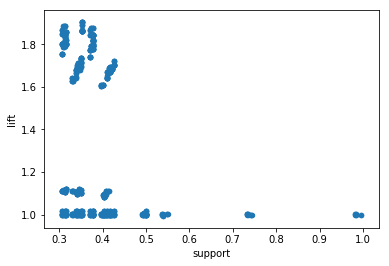

In [19]:
rules = pd.read_csv("/home/wangxuefei/Data_mining/result_1.csv",index_col=0)
#print(rules)
#rules['lift'].plot.hist(grid=False,bins=20,title='price')
rules.plot.scatter(x='support', y='lift')
plt.show()

#### （2）观察 “confidence”与“lift”之间的分布关系，发现 总体趋势是 lift 与 confidence 正相关，即随着confidence的增大，lift也在增大

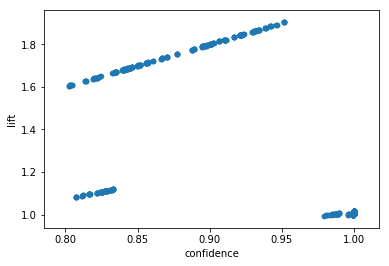

In [20]:
rules.plot.scatter(x='confidence', y='lift')
plt.show()

####  （3）观察 “support”与“cosine”之间的分布关系，总体也有正相关的趋势

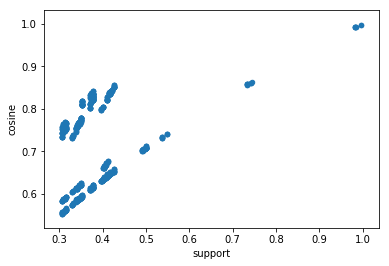

In [21]:
rules.plot.scatter(x='support', y='cosine')
plt.show()

#### （4）观察 “confidence”与“cosine”之间的分布关系，总体趋势较为离散，也没有明显的线性关系

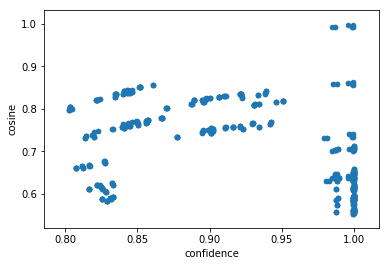

In [22]:
rules.plot.scatter(x='confidence', y='cosine')
plt.show()